# Daily Time Series forecasting using Facebook's Prophet
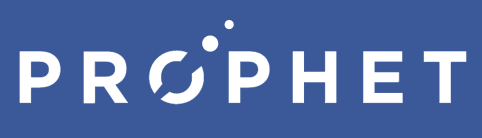

Goal of this kernel is to do timeseries analysis and predict next 2 months sales using Facebook Prophet 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from fbprophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

### Read the dataset

In [ ]:
df = pd.read_excel("../input/groceries-sales-data/Groceries_Sales_data.xlsx",parse_dates=[0])

### Head & Tail of the dataframe

In [ ]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

In [ ]:
df.info()

In [ ]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("Daily Sales Data",fontsize=15)
plt.show()

# Exploratory Data Analysis

Creates time series features from Date column.

In [ ]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='Sales')
df_new = pd.concat([X, y], axis=1)
df_new.head()

## Plotting the Features to see trends
* Sales has strong daily and seasonal properties.
* Day of week also seems to show differences in peaks

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Sales",hue = 'year',data=df_new)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [ ]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="month",y="Sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="dayofweek",y="Sales",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="quarter",y="Sales",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="year",y="Sales",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)

In [ ]:
df=df.rename(columns={'Date':'ds','Sales':'y'})
df.head()

Dividing the dataset into train and test. The train has data from Feb,2018 to Dec,2019. Test Data has 2 months from Jan,2020 to Feb,2020.

In [ ]:
end_date = '2019-12-31'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [ ]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

In [ ]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Simple Prophet Model

In [ ]:
model =Prophet()
model.fit(X_tr)

Now, we will predict by creating future dataframe next dates of train data. make_future_dataframe has include_history = True by default. So the predcition will be done for train data as well.

In [ ]:
future = model.make_future_dataframe(periods=57, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Plot the components of the model
fig = model.plot_components(forecast)

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

## Actual vs Prediction Comparison

In [ ]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

### Compare the test Sales and forecasted Sales

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)
ax.set_xbound(lower='2020-01-01', upper='2020-01-08')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

### Adding Holidays to the model
We will use **holidays** library to get the US holidays

In [ ]:
import holidays

In [ ]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
holiday.head()

In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

In [ ]:
future = model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

In [ ]:
# Plot the components of the model
fig = model_with_holidays.plot_components(forecast)

In [ ]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

From the above results, we can see that by adding holidays in the model, model performance further reduced. We need to add other parameters to tune the model.

Along with holidays, there are many other hyperparameters which helps in optimizing the prophet model.
1. Holidays
2. Changepoints: (n_changepoints,changepoint_prior_scale)
4. seasonality_mode
5. holiday_prior_scale
6. Seasonalities with fourier_order

We have added holidays to our model and saw its effect. 

**n_changepoints** is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing *n_changepoints* can add value to the model.

**changepoint_prior_scale** to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

**seasonality_mode** There are 2 types model seasonality mode. **Additive & multiplicaticative**. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

**holiday_prior_scale** just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

**Seasonalities with fourier_order** Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.


Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination.
I am taking 4 parameters: n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale for tuning.

# HyperParameter Tuning using ParameterGrid

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

# Prophet Model Tuning

In [ ]:
strt='2019-12-31'
end='2020-02-26'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=57, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

Out of total 150 models, we will select the parameters which has the least MAPE to train the final model and predict the next 2 months sales of the store.

Best Parameters on which the model has the least MAPE is:

In [ ]:
parameters['Parameters'][0]

In [ ]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

In [ ]:
future = final_model.make_future_dataframe(periods=122, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [ ]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [ ]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

from the above, results, we can see there is significant improvement in MAPE. We can further improve the model by changing the fourier order of the seasonalities and by including more features and add them as additional regressors.


***P.S: Please upvote this kernel if you find this useful.***